# Hot Hand Final Project

## Data Exploration

** Chip, Toni, Tommy, Kyle ** 11/4/16

In [2]:
## Load necessary libraries
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
import StringIO
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
## Read in data
shot_logs_full = pd.read_csv('datasets/shot_logs.csv')
shot_logs_full.columns = map(str.lower, shot_logs_full.columns)

# Preview data
print 'Number of variables:', np.shape(shot_logs_full)[1]
print 'Variable names:', shot_logs_full.columns.values
print 'Number of observations/shots:', np.shape(shot_logs_full)[0]
shot_logs_full.head()

Number of variables: 21
Variable names: ['game_id' 'matchup' 'location' 'w' 'final_margin' 'shot_number' 'period'
 'game_clock' 'shot_clock' 'dribbles' 'touch_time' 'shot_dist' 'pts_type'
 'shot_result' 'closest_defender' 'closest_defender_player_id'
 'close_def_dist' 'fgm' 'pts' 'player_name' 'player_id']
Number of observations/shots: 128069


,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,shot_dist,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


Number of unique player-game combinations where the player took a shot: 14343
Mean number of shots per game per player (given they have taken one): 8.92902461131


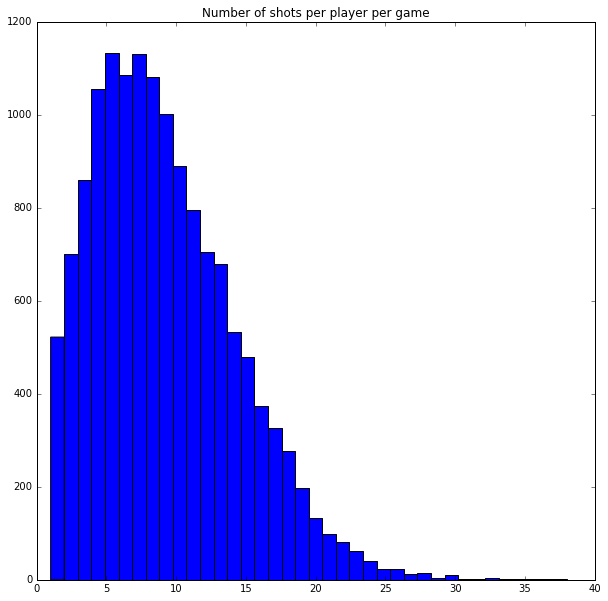

In [4]:
## Determine players with min number of shots taken per game to be included in analysis

# Group observations by unique values of player_id and game_id
gp = shot_logs_full.groupby(['player_id', 'game_id'])

# Create array that has shots per game for each unique value of player_id and game_id 
# (computationally expensive/inefficient, lmk if you have other ideas)
shots_per_game_per_player = []
for g in gp.groups.items():
    shots_per_game_per_player.append(np.shape(shot_logs_full.loc[g[1]])[0])
    
print 'Number of unique player-game combinations where the player took a shot:', len(shots_per_game_per_player)
print 'Mean number of shots per game per player (given they have taken one):', np.mean(shots_per_game_per_player)

# Histogram of number of shots per player per game
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.hist(shots_per_game_per_player, bins = 38)
ax1.set_title('Number of shots per player per game')
plt.show()

** Comment: **
Given the above information, I would drop all players with less than **5** (maybe 4) shots per game. This is substantially below the mean (above) and the median (8). Intuitively, this seems legit, i.e., I think we can consider the prior belief that it is incredibly unlikely for players who have taken 4 or less shots to have the hot hand. Open to other interpretation though!

In [26]:
## Create new dataframe with only player-game combos where each player had more than 4 shots taken

# Create holding array
df_list = []

# Create array that has shots per game for each unique value of player_id and game_id 
# (again, computationally expensive/inefficient, lmk if you have other ideas)
for g in gp.groups.items():
    if (np.shape(shot_logs_full.loc[g[1]])[0] > 4):
        df_list.append(shot_logs_full.loc[g[1]])
        
# Concatenate df's that meet 5+ shot criteria
shot_logs_reduced = pd.concat(df_list)

In [27]:
# Preview reduced logs
print 'Number of observations/shots:', np.shape(shot_logs_reduced)[0]
shot_logs_reduced.head()

Number of observations/shots: 119341


,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,shot_dist,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id
28621,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,1,1,2:29,22.1,0,...,26.2,3,made,"Roberts, Brian",203148,4.4,1,3,ryan anderson,201583
28622,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,2,2,11:19,5.8,2,...,18.2,2,made,"Zeller, Cody",203469,6.1,1,2,ryan anderson,201583
28623,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,3,2,10:51,10.2,2,...,20.4,2,missed,"Maxiell, Jason",101131,5.7,0,0,ryan anderson,201583
28624,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,4,2,8:21,24.0,0,...,2.5,2,made,"Zeller, Cody",203469,2.6,1,2,ryan anderson,201583
28625,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,5,2,7:59,16.0,0,...,26.0,3,missed,"Zeller, Cody",203469,6.5,0,0,ryan anderson,201583


Mean Field Goal Percentage: 0.455301601942


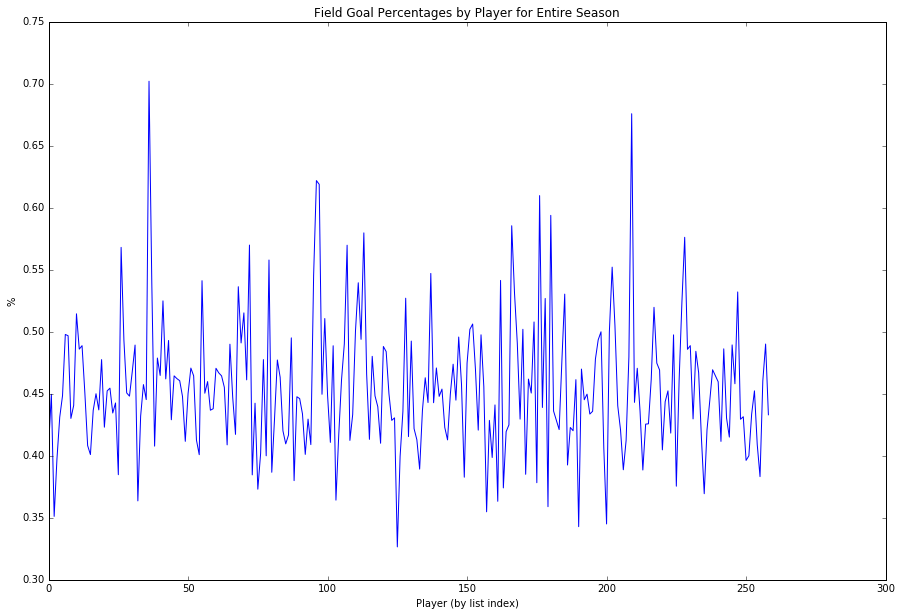

In [29]:
# Toni's work 

## Goal: Calculate field goal percentage for each player and determine top 5 shooters based on FG%

# for each player_id, count total number of shots and total number of field goals made (column name 'fgm')

# first get the player_ids
players = shot_logs_reduced['player_id'].unique()

# remove all players who haven't played at least 15 games in order to reduce sample size effects (15 is a little arbitrary, can be adjusted if needed)
for player in players:
    # dataset specific to given player
    player_df = shot_logs_reduced[shot_logs_reduced['player_id'] == player]
    if len(player_df['game_id'].unique()) < 15:
        shot_logs_reduced = shot_logs_reduced[shot_logs_reduced['player_id'] != player]



# create list to store fg%
fg_percentages = []

# now get total shots and total made (if you get a 'float division by zero' error, just run this cell again)
for player in players:
    # get data specific to the given player
    player_data = shot_logs_reduced[shot_logs_reduced['player_id'] == player]
    total_shots = player_data.shape[0]
    total_made = player_data[player_data['fgm'] == 1].shape[0]
    
    # calculate field goal %
    fg_percent = float(total_made) / total_shots
    fg_percentages.append(fg_percent)
    

# get mean fg%
fg_percentages = np.array(fg_percentages)
print "Mean Field Goal Percentage: {0}".format(fg_percentages.mean())

# plot field goal % for each player to see general numbers for all selected players
# x-axis will just be the index of the player in the players list; we can map it back to specific id later
plt.figure(figsize=(15, 10))
plt.plot(range(len(players)), fg_percentages)
plt.title('Field Goal Percentages by Player for Entire Season')
plt.ylabel('%')
plt.xlabel('Player (by list index)')

**Comment:** This graph shows us deviations of the field goal percentage made by each player. It shows us how much variation there may be in our data. Not sure how useful this will be in the future, but for now it will help us identify the top 5 shooters by field goal percentage. We can then examine more specific data with just the top 5 shooters.

In [30]:
# get top 5 shooting percentages 
# (argsort will return a list of the indices that would result in a sorted order)
fg_percentages_sorted = np.argsort(fg_percentages)
# get 5 max coefficients
max_index = len(fg_percentages_sorted)
max_percentages_indices = fg_percentages_sorted[(max_index - 5):max_index]

# then associate these indices with the players and fg%
top_5_players = players[max_percentages_indices]
top_5_fg_percents = fg_percentages[max_percentages_indices]

## create dataframe for just the top 5 players

# first create temp holding array
df_list = []
for player in top_5_players:
    df_list.append(shot_logs_reduced[shot_logs_reduced['player_id'] == player])
# then create full df
top_5_df = pd.concat(df_list)

print "Top 5 Players by Field Goal Percentage: {0}".format(top_5_df['player_name'].unique())

Top 5 Players by Field Goal Percentage: ['ed davis' 'mason plumlee' 'james johnson' 'tyson chandler'
 'deandre jordan']


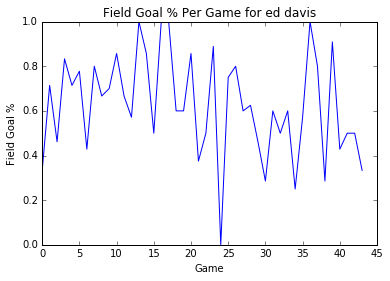

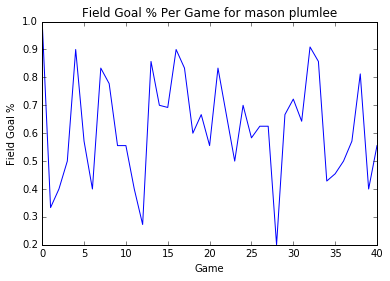

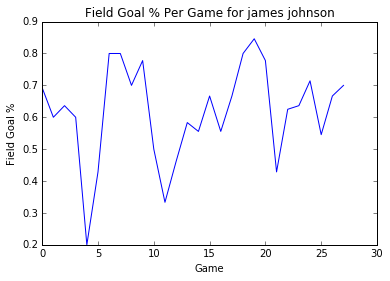

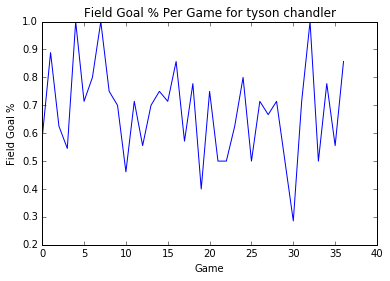

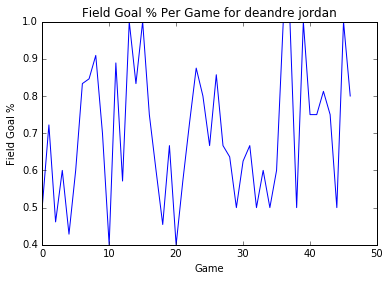

In [31]:
# now for each of the top 5 players, let's calculate and plot fg% for each game in the full season
for player in top_5_players:
    # create list to store field goal % for each game
    fg_percent_per_game = []
    # calculate fg% for each game
    player_df = top_5_df[top_5_df['player_id'] == player]
    for game in player_df['game_id'].unique():
        # get data specific to the given game
        game_data = top_5_df[top_5_df['game_id'] == game]
        total_shots = game_data.shape[0]
        total_made = game_data[game_data['fgm'] == 1].shape[0]
        
        # calculate fg% and append to list
        fg_percent = float(total_made) / total_shots
        fg_percent_per_game.append(fg_percent)
    
    # get player name
    player_name = top_5_df[top_5_df['player_id'] == player]['player_name'].unique()
    # now plot across the full season
    plt.figure()
    plt.plot(range(len(fg_percent_per_game)), fg_percent_per_game)
    plt.title('Field Goal % Per Game for ' + player_name[0])
    plt.xlabel('Game')
    plt.ylabel('Field Goal %')
        

**Comment:** This field goal % per game metric allows us to see how well the top 5 players are shooting across the season. It could be useful information if we're looking at Hot Hand Theory at a macroscopic level (i.e. getting hot at different points in the season).

In [33]:
## Now let's look at tracking shooting streaks in the game (both hot and cold)
# Methodology: Let each made shot have a value of +1 and each missed shot a value of -1
# For each consecutive make, add one. If the next shot is missed, then set the current streak value to 
# -1. If there are consecutive misses, subtract 1 for each miss. If the next shot is made, then set the 
# current streak value to +1. 

# create holding array for current streak values
current_streak = []

# We'll append a current streak column to our shot_logs_reduced dataframe
number_of_rows = shot_logs_reduced.shape[0]

for index in range(number_of_rows):
    row = shot_logs_reduced.iloc[index]
    # handle if we're looking at the first row of our data, since there's no previous row
    if index == 0:
        # if made, set streak to +1
        if row['fgm']:
            current_streak.append(1)
        else:
            current_streak.append(-1)
    else:
        # first get some useful information from the selected row and the previous row
        previous_row = shot_logs_reduced.iloc[index - 1]
        previous_game_id = previous_row['game_id']
        previous_streak = current_streak[index - 1]
        game_id = row['game_id']
        
        # check to see if we're still in the same game
        if game_id == previous_game_id:
            # handle calculation of streak after given shot
            updated_streak = previous_streak
            # if on a hot streak  
            if previous_streak > 0:
                # and next shot is made
                if row['fgm']:
                    updated_streak += 1
                # and next shot is missed
                else:
                    updated_streak = -1
            # if on a cold streak
            else:
                # and next shot is made
                if row['fgm']:
                    updated_streak = 1
                # and next shot is missed
                else:
                    updated_streak -= 1
            # add updated_streak to current_streak list
            current_streak.append(updated_streak)
        # if we're in a different game than before, set streak score accordingly
        else:
            if row['fgm']:
                current_streak.append(1)
            else:
                current_streak.append(-1)


In [34]:
# add this current_streak count to our dataframe as a new column
shot_logs_reduced['current_streak'] = current_streak

# now get updated top 5 player dataframe
# first create temp holding array
df_list = []
for player in top_5_players:
    df_list.append(shot_logs_reduced[shot_logs_reduced['player_id'] == player])
# then create full df
top_5_df = pd.concat(df_list)

In [43]:
# let's look to see how many hot and cold streaks our top 5 players get on (defining a streak as >= 4 shots made/missed in a row as defined in lit review)
for player in top_5_players:
    player_df = top_5_df[top_5_df['player_id'] == player]
    hot_streaks = player_df[player_df['current_streak'] >= 4]
    cold_streaks = player_df[player_df['current_streak'] <= -4]

    
    ########### TO DO: Don't double count streaks ###################

22 11
36 3
21 5
33 3
54 2
